# Modeling Notebook:

### This notebook includes the code for training, testing, and comparing our models. We use five different modeling approachs to find the best, compairing MSE and $R^2$.

### The models we experiment with include:
- ExtraTrees
- AdaBoost
- RandomForest
- GradientBoosting
- XGBoost

### We extract feature importance scores from each model to inform our index construction.

In [1]:
import pandas as pd
import numpy as np
import time
from print_imps import print_importances
import joblib
import seaborn as sns
import matplotlib.pyplot as plt
import shap
import pickle

from skopt import BayesSearchCV
from skopt.space import Categorical, Real, Integer
from sklearn.svm import SVR
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn import metrics, linear_model
from sklearn.linear_model import LinearRegression
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, ExtraTreesRegressor, AdaBoostRegressor
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler

from xgboost import XGBRegressor
from scipy.stats import randint, uniform

import os
os.chdir('/sfs/qumulo/qhome/bdr6qz/Documents/MSDS/DS6050')

import multiprocessing
# Get the number of CPU cores
n_jobs = multiprocessing.cpu_count()

In [2]:
# Load the data
df = pd.read_csv('df_clean.csv')
df_last = pd.read_csv('df_last.csv')
label_col_name = "mvp_share"
labels = df.pop(label_col_name)
stratify = df.pop("Rank")
df_selected = pd.read_csv('df_selected.csv')
feature_names = list(df_selected.columns)

In [3]:
feature_names

['VORP',
 'PER',
 'WS',
 'WS/48',
 'OBPM',
 'BPM',
 'OWS',
 'Rk_Conf',
 'FG',
 'Overall']

In [4]:
# Split the data into training and testing sets
X_train_selected, X_test_selected, y_train, y_test = train_test_split(df_selected, 
                                                                      labels, 
                                                                      test_size=0.2, 
                                                                      stratify=stratify, 
                                                                      random_state=28)

# Convert to arrays
y_train = y_train.values
y_test = y_test.values
X_train = X_train_selected.values
X_test = X_test_selected.values

---

# ExtraTreesRegressor

In [6]:
start_time = time.time()

# Define the hyperparameter search space for ExtraTreesRegressor
param_space = {
    'n_estimators': (100, 500),      # No. of trees in the forest
    'max_depth': (3, 10),            # Max depth of each tree
    'min_samples_split': (2, 20),    # Min no. of samples required to split an internal node
    'min_samples_leaf': (1, 10),     # Min no. of samples required to be at a leaf node
    'max_features': (0.1, 1.0),      # No. of features to consider when looking for the best split
    'bootstrap': [True, False]       # Whether to use bootstrap samples when building trees
}

# Initialize ExtraTreesRegressor
extra_trees_model = ExtraTreesRegressor(random_state=28)

# Initialize BayesSearchCV
bayes_search_Xtrees = BayesSearchCV(estimator=extra_trees_model,
                             search_spaces=param_space,
                             n_iter=100,
                             scoring='r2',
                             cv=5,
                             n_points=9,
                             random_state=28,
                             n_jobs=n_jobs)

# Perform Bayesian Optimization
bayes_search_Xtrees.fit(X_train, y_train)

# Get the best hyperparameters
best_params = bayes_search_Xtrees.best_params_
print("Best Hyperparameters:", best_params)

# Get the best model
best_Xtrees = bayes_search_Xtrees.best_estimator_

# Make predictions on the test data using the best model
y_pred_Xtrees = best_Xtrees.predict(X_test)

# Evaluate the best model using mean squared error and R-squared
test_mse_Xtrees = mean_squared_error(y_test, y_pred_Xtrees)
test_r2_Xtrees = r2_score(y_test, y_pred_Xtrees)

print("Test MSE (Best ExtraTreesRegressor):", test_mse_Xtrees)
print("Test R-squared (Best ExtraTreesRegressor):", test_r2_Xtrees)

end_time = time.time()
execution_time = end_time - start_time

print(f"Model execution time: {round(execution_time/60, 2)} minutes")

Best Hyperparameters: OrderedDict([('bootstrap', True), ('max_depth', 10), ('max_features', 0.49011764505469213), ('min_samples_leaf', 1), ('min_samples_split', 3), ('n_estimators', 378)])
Test MSE (Best ExtraTreesRegressor): 0.0014068668403230075
Test R-squared (Best ExtraTreesRegressor): 0.7243164315026869
Model execution time: 1.76 minutes


In [7]:
print_importances(feature_names, best_Xtrees)

Feature Importances:
WS : 0.1605097067213737
VORP : 0.13638681454805024
PER : 0.1250918936399096
BPM : 0.10342658585159158
WS/48 : 0.09816707328411535
OWS : 0.09026600414782786
OBPM : 0.08701390504275684
Rk_Conf : 0.07369945396389843
FG : 0.06509545997615236
Overall : 0.06034310282432408


---

# AdaBoostRegressor

In [8]:
start_time = time.time()

# Define the hyperparameter search space for AdaBoostRegressor
param_space = {
    'n_estimators': (50, 500),                   # No. of base estimators
    'learning_rate': (0.01, 1.0),                # Learning rate to shrink each base estimator's contribution
    'loss': ['linear', 'square', 'exponential']  # Loss function to update weights
}

# Initialize AdaBoostRegressor
adaboost_model = AdaBoostRegressor(random_state=28)

# Initialize BayesSearchCV
bayes_search_Ada = BayesSearchCV(estimator=adaboost_model,
                                 search_spaces=param_space,
                                 n_iter=100,
                                 scoring='r2',
                                 cv=5,
                                 n_points=10,
                                 random_state=28,
                                 n_jobs=n_jobs)

# Perform Bayesian Optimization
bayes_search_Ada.fit(X_train, y_train)

# Get the best hyperparameters
best_params = bayes_search_Ada.best_params_
print("Best Hyperparameters:", best_params)

# Get the best model
best_Ada = bayes_search_Ada.best_estimator_

# Make predictions on the test data using the best model
y_pred_Ada = best_Ada.predict(X_test)

# Evaluate the best model using mean squared error and R-squared
test_mse_Ada = mean_squared_error(y_test, y_pred_Ada)
test_r2_Ada = r2_score(y_test, y_pred_Ada)

print("Test MSE (Best AdaBoostRegressor):", test_mse_Ada)
print("Test R-squared (Best AdaBoostRegressor):", test_r2_Ada)

end_time = time.time()
execution_time = end_time - start_time

print(f"Model execution time: {round(execution_time/60, 2)} minutes")

Best Hyperparameters: OrderedDict([('learning_rate', 0.01), ('loss', 'exponential'), ('n_estimators', 128)])
Test MSE (Best AdaBoostRegressor): 0.0016862954461485029
Test R-squared (Best AdaBoostRegressor): 0.6695608050380563
Model execution time: 1.88 minutes


In [9]:
print_importances(feature_names, best_Ada)

Feature Importances:
PER : 0.3125286042140531
WS : 0.2953071083629948
VORP : 0.14853904996799486
Rk_Conf : 0.12671832426291327
Overall : 0.034767466249641374
BPM : 0.030376843826081374
WS/48 : 0.022521913291571983
FG : 0.016345886952556385
OBPM : 0.007327316289456562
OWS : 0.005567486582736483


---

# Random Forest

In [10]:
start_time = time.time()

# Define the hyperparameter grid
param_grid_rf = {
    'n_estimators': [100, 200, 300],    # No. of trees in the forest
    'max_features': ['log2', 'sqrt'],   # No. of features to consider at every split
    'max_depth': [None, 10, 20],        # Max depth of the trees
    'min_samples_split': [2, 5, 10],    # Min no. of samples required to split an internal node
    'min_samples_leaf': [1, 2, 4],      # Min no. of samples required to be at a leaf node
    'bootstrap': [True, False]          # Method to select samples for training each tree
}

# Initialize XGBRegressor
rf = RandomForestRegressor(random_state=28)

# Initialize BayesSearchCV
bayes_rf = BayesSearchCV(estimator=rf, 
                         search_spaces=param_grid_rf,
                         n_iter=100, 
                         scoring='r2', 
                         cv=5, 
                         random_state=28,
                         n_points=10,
                         n_jobs=n_jobs)

# Perform Bayesian Optimization
bayes_rf.fit(X_train, y_train)

# Get the best hyperparameters
best_params_rf = bayes_rf.best_params_
print("Best Hyperparameters (Random Forest):", best_params_rf)

# Get the best model
best_rf = bayes_rf.best_estimator_

# Make predictions on the test data using the best model
y_pred_rf = best_rf.predict(X_test)

# Evaluate the best model using mean squared error and R-squared
test_mse_rf = mean_squared_error(y_test, y_pred_rf)
test_r2_rf = r2_score(y_test, y_pred_rf)

print("Test MSE (Best Random Forest):", test_mse_rf)
print("Test R-squared (Best Random Forest):", test_r2_rf)

end_time = time.time()
execution_time = end_time - start_time
print(f"Model execution time: {round(execution_time/60, 2)} minutes")

Best Hyperparameters (Random Forest): OrderedDict([('bootstrap', True), ('max_depth', 10), ('max_features', 'log2'), ('min_samples_leaf', 4), ('min_samples_split', 10), ('n_estimators', 100)])
Test MSE (Best Random Forest): 0.0014350561169395625
Test R-squared (Best Random Forest): 0.7187925822311911
Model execution time: 2.61 minutes


In [11]:
print_importances(feature_names, best_rf)

Feature Importances:
WS : 0.21769703621524628
PER : 0.16217303821585763
VORP : 0.15443678119284507
OBPM : 0.09420735011639847
BPM : 0.07893828037632153
WS/48 : 0.07008979636853561
Rk_Conf : 0.0660677222570879
Overall : 0.06322853599134723
OWS : 0.0551983964830314
FG : 0.037963062783328845


---

# Gradient Boosting Regressor

In [12]:
start_time = time.time()

# Define the hyperparameter grid
param_grid_gb = {
    'n_estimators': [100, 300],       # No. of boosting stages
    'learning_rate': [0.05, 0.1],     # Learning rate
    'max_depth': [3, 5],              # Max depth of the individual trees
    'min_samples_split': [2, 5],      # Min no. of samples required to split an internal node
    'min_samples_leaf': [1, 2],       # Min no. of samples required to be at a leaf node
    'subsample': [0.6, 0.8],          # Fraction of samples used to fit individual base learners
    'max_features': ['log2', 'sqrt']  # No. of features to consider when looking for best split
}

# Initialize GradientBoostingRegressor
gb_model = GradientBoostingRegressor(random_state=28)

# Initialize BayesSearchCV
bayes_search_gb = BayesSearchCV(estimator=gb_model, 
                                search_spaces=param_grid_gb,
                                n_iter=100, 
                                scoring='r2', 
                                cv=5,
                                n_points=10,
                                n_jobs=n_jobs,
                                random_state=28)

# Perform random search
bayes_search_gb.fit(X_train, y_train)

# Get the best hyperparameters
best_params_gb = bayes_search_gb.best_params_
print("Best Hyperparameters (Gradient Boosting):", best_params_gb)

# Get the best model
best_gb = bayes_search_gb.best_estimator_

# Make predictions on the test data using the best model
y_pred_gb = best_gb.predict(X_test)

# Evaluate the best model using mean squared error and R-squared
test_mse_gb = mean_squared_error(y_test, y_pred_gb)
test_r2_gb = r2_score(y_test, y_pred_gb)

print("Test MSE:", test_mse_gb)
print("Test R-squared:", test_r2_gb)

end_time = time.time()
execution_time = end_time - start_time
print(f"Model execution time: {round(execution_time/60, 2)} minutes")

Dimension [100, 300] was inferred to Integer(low=100, high=300, prior='uniform', transform='identity'). In upcoming versions of scikit-optimize, it will be inferred to Categorical(categories=(100, 300), prior=None). See the documentation of the check_dimension function for the upcoming API.
Dimension [0.05, 0.1] was inferred to Real(low=0.05, high=0.1, prior='uniform', transform='identity'). In upcoming versions of scikit-optimize, it will be inferred to Categorical(categories=(0.05, 0.1), prior=None). See the documentation of the check_dimension function for the upcoming API.
Dimension [3, 5] was inferred to Integer(low=3, high=5, prior='uniform', transform='identity'). In upcoming versions of scikit-optimize, it will be inferred to Categorical(categories=(3, 5), prior=None). See the documentation of the check_dimension function for the upcoming API.
Dimension [2, 5] was inferred to Integer(low=2, high=5, prior='uniform', transform='identity'). In upcoming versions of scikit-optimize,

Best Hyperparameters (Gradient Boosting): OrderedDict([('learning_rate', 0.05), ('max_depth', 3), ('max_features', 'sqrt'), ('min_samples_leaf', 1), ('min_samples_split', 3), ('n_estimators', 100), ('subsample', 0.8)])
Test MSE: 0.001521305878915146
Test R-squared: 0.7018914502391871
Model execution time: 1.36 minutes


In [13]:
print_importances(feature_names, best_gb)

Feature Importances:
VORP : 0.19226413634143547
PER : 0.14582527302686218
WS : 0.1318965783685779
OBPM : 0.09632885336606556
WS/48 : 0.09268153370138149
BPM : 0.08642338300589879
Overall : 0.07577696744197862
Rk_Conf : 0.07529472876279654
FG : 0.05268099508272611
OWS : 0.05082755090227722


---

## XGBoost Regressor

In [14]:
start_time = time.time()

# Define the hyperparameter search space
param_space = {
    'n_estimators': (100, 500),      # No. of trees in the forest
    'learning_rate': (0.01, 0.3),    # Learning rate
    'max_depth': (3, 10),            # Max depth of each tree
    'min_child_weight': (1, 10),     # Min sum of instance weight needed in a child
    'subsample': (0.6, 1.0),         # Subsample ratio of the training instance
    'colsample_bytree': (0.6, 1.0),  # Subsample ratio of columns when constructing each tree
    'gamma': (0, 0.5),               # Min loss reduction to further partition on a leaf node
    'reg_alpha': (0, 1.0),           # L1 reg term on weights
    'reg_lambda': (0, 1.0)           # L2 reg term on weights
}

# Initialize XGBRegressor
xgb_model = XGBRegressor(random_state=28)

# Initialize BayesSearchCV
bayes_search = BayesSearchCV(estimator=xgb_model, 
                             search_spaces=param_space,
                             n_iter=100, 
                             scoring='r2', 
                             cv=5,
                             n_points=10,
                             random_state=28, 
                             n_jobs=n_jobs)

# Perform Bayesian Optimization
bayes_search.fit(X_train, y_train)

# Get the best hyperparameters
best_params = bayes_search.best_params_
print("Best Hyperparameters:", best_params)

# Get the best model
best_xgb = bayes_search.best_estimator_

# Make predictions on the test data using the best model
y_pred_xgb = best_xgb.predict(X_test)

# Evaluate the best model using mean squared error and R-squared
test_mse_xgb = mean_squared_error(y_test, y_pred_xgb)
test_r2_xgb = r2_score(y_test, y_pred_xgb)

print("Test MSE (Best XGBoost):", test_mse_xgb)
print("Test R-squared (Best XGBoost):", test_r2_xgb)

end_time = time.time()
execution_time = end_time - start_time

print(f"Model execution time: {round(execution_time/60, 2)} minutes")

Best Hyperparameters: OrderedDict([('colsample_bytree', 0.6), ('gamma', 0.07954844829039878), ('learning_rate', 0.1560738525819043), ('max_depth', 6), ('min_child_weight', 2), ('n_estimators', 201), ('reg_alpha', 0.9528738698119049), ('reg_lambda', 0.373373106885102), ('subsample', 0.7253652752482744)])
Test MSE (Best XGBoost): 0.0012889376716949097
Test R-squared (Best XGBoost): 0.7474253236206154
Model execution time: 1.42 minutes


In [15]:
print_importances(feature_names, best_xgb)

Feature Importances:
WS : 0.34365535
VORP : 0.2169757
OBPM : 0.107329674
PER : 0.08953816
OWS : 0.069519885
Overall : 0.056036875
Rk_Conf : 0.04041323
WS/48 : 0.028687324
FG : 0.025385926
BPM : 0.022457873


---

# Model Comparisons

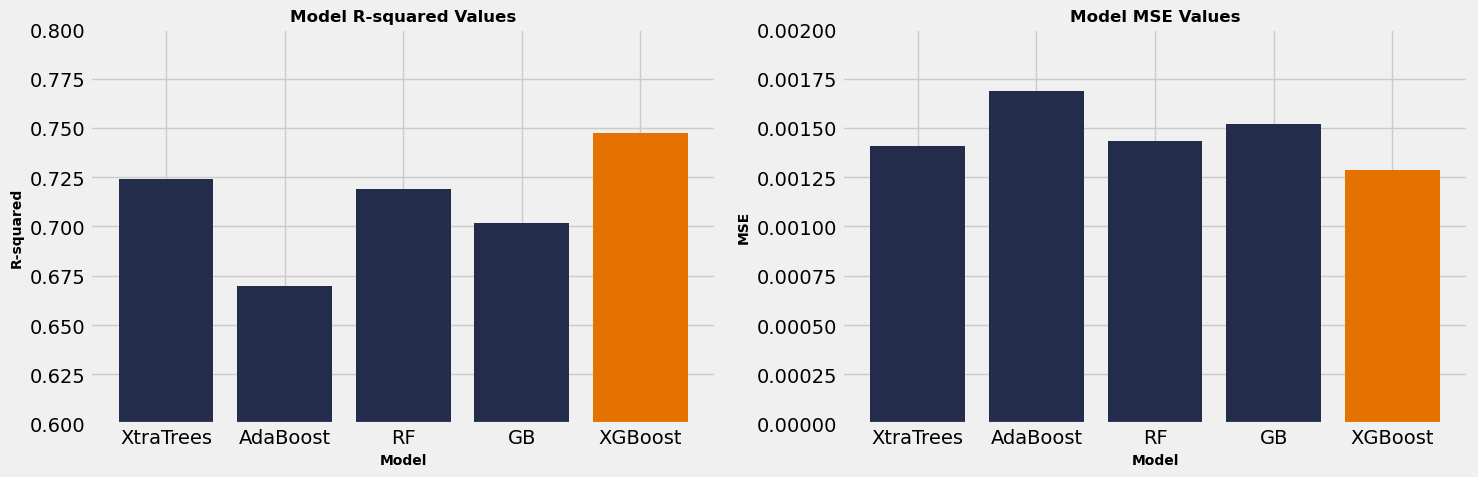

In [25]:
# Data for R-squared values
r_sqs = [test_r2_Xtrees, test_r2_Ada, test_r2_rf, test_r2_gb, test_r2_xgb]

# Data for MSE values
MSE_s = [test_mse_Xtrees, test_mse_Ada, test_mse_rf, test_mse_gb, test_mse_xgb]

# List of model names
model_names = ['XtraTrees', 'AdaBoost', 'RF', 'GB', 'XGBoost']

# Determine colors for R-squared bars
r_sq_colors = ['#E57200' if r == max(r_sqs) else '#232D4B' for r in r_sqs]

# Determine colors for MSE bars
mse_colors = ['#E57200' if mse == min(MSE_s) else '#232D4B' for mse in MSE_s]

plt.style.use('fivethirtyeight')

# Create a figure with two subplots
fig, axs = plt.subplots(1, 2, figsize=(15, 5))

# Plot the R-squared values
axs[0].bar(model_names, r_sqs, color=r_sq_colors)
axs[0].set_xlabel('Model', fontdict={'fontsize': 10, 'fontweight': 'bold'})
axs[0].set_ylabel('R-squared', fontdict={'fontsize': 10, 'fontweight': 'bold'})
axs[0].set_title('Model R-squared Values', fontdict={'fontsize': 12, 'fontweight': 'bold'})
axs[0].tick_params(axis='x', rotation=0)
axs[0].set_ylim(0.6, 0.8)

# Plot the MSE values
axs[1].bar(model_names, MSE_s, color=mse_colors)
axs[1].set_xlabel('Model', fontdict={'fontsize': 10, 'fontweight': 'bold'})
axs[1].set_ylabel('MSE', fontdict={'fontsize': 10, 'fontweight': 'bold'})
axs[1].set_title('Model MSE Values', fontdict={'fontsize': 12, 'fontweight': 'bold'})
axs[1].tick_params(axis='x', rotation=0)
axs[1].set_ylim(0, 0.002)

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plot
plt.show()

In [23]:
# Save the best model
joblib.dump(best_xgb, 'best_xgb_model.pkl')

['best_xgb_model.pkl']